In [1]:
import os.path
import datetime
import numpy as np
from math import sqrt
from pandas import read_csv, to_datetime, DataFrame, concat, date_range
from pandas.tseries.offsets import DateOffset

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
%matplotlib inline

from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
import tensorflow as tf
tf.random.set_seed(7)

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
save_path = 'D:/Study/Academic/Research/Master Degree/Master Work/Software/Codes/Python/LSTM Py examples/'
try:
    os.mkdir(save_path + 'Output_figures')
except OSError as error:
    print(error)

In [4]:
df_raw = read_csv('data.csv', index_col='DateTime')
df_raw.head()

,X1,X2,X3,Y
DateTime,,,,
1/1/1976 0:00,1.039535,-7.696444,-12.319973,-0.420216
1/1/1976 1:00,1.039535,-7.696444,-12.479278,-0.420216
1/1/1976 2:00,1.039535,-7.696444,-12.479278,-0.420216
1/1/1976 3:00,1.039535,-7.696444,-12.479278,-0.468521
1/1/1976 4:00,1.039535,-7.696444,-12.479278,-0.494850


In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78912 entries, 1/1/1976 0:00 to 12/31/1984 23:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      78912 non-null  float64
 1   X2      78912 non-null  float64
 2   X3      78912 non-null  float64
 3   Y       78912 non-null  float64
dtypes: float64(4)
memory usage: 3.0+ MB


### Hourly data - last 500 timesteps 

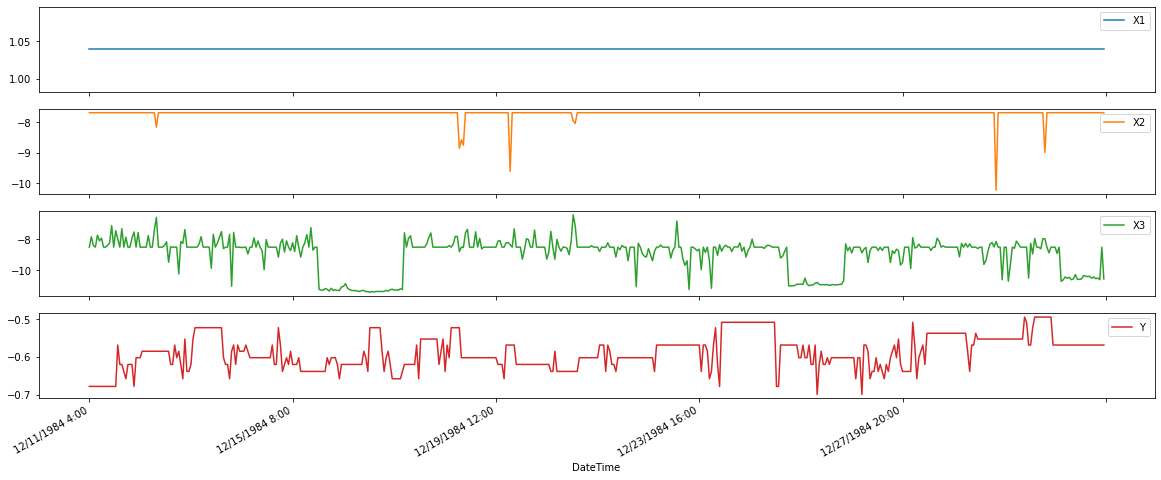

In [6]:
df_raw[-500:].plot(figsize=(20,8), subplots=True)
plt.show()

In [7]:
df_raw = read_csv('data.csv')
df_raw['DateTime'] = to_datetime(df_raw['DateTime'])
df_raw = df_raw.set_index('DateTime')
df_raw = df_raw.resample('12H').asfreq() # for resampling data 

### 12-hour data - last 500 timesteps 

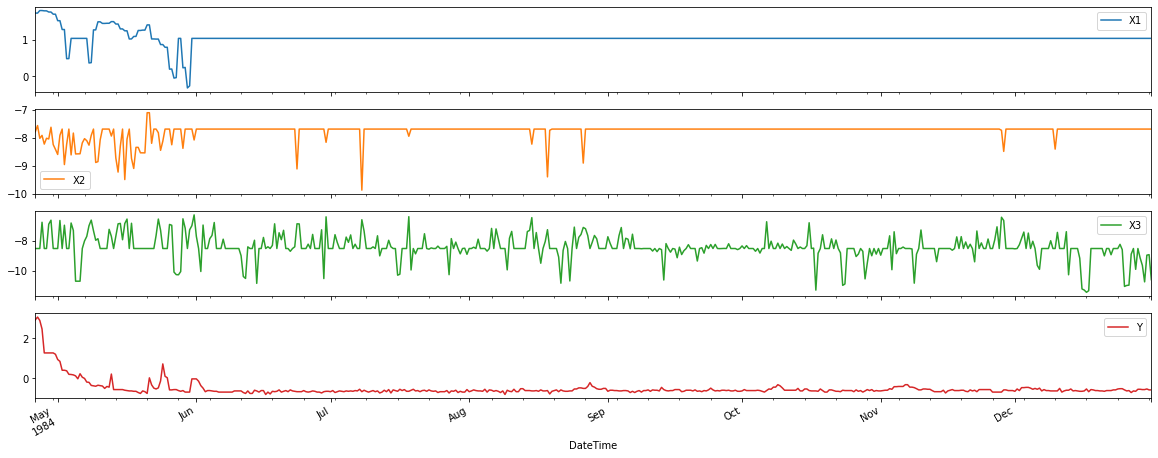

In [8]:
df_raw[-500:].plot(figsize=(20,8), subplots=True)
plt.show()

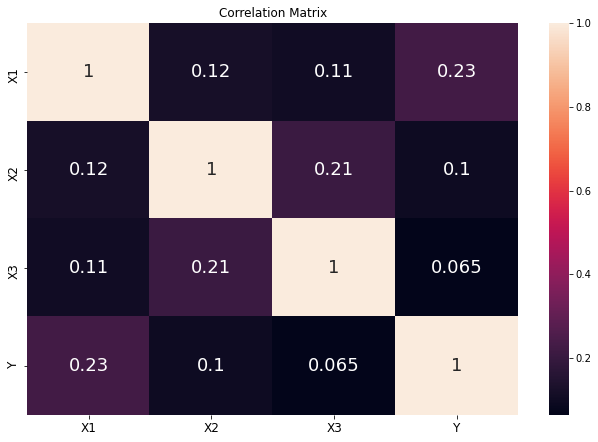

In [9]:
# Inspect the correlation between variables - raw data 
corr = df_raw.corr()
ax = sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, annot_kws={'size':18})
heat_map = plt.gcf()
heat_map.set_size_inches(11,8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Correlation Matrix')
ax.figure.subplots_adjust(bottom = 0.2)
# plt.savefig('corr_mat.png')
plt.show()

In [10]:
# normalizing the data 
scaler = MinMaxScaler()
scaler.fit(df_raw)
df = scaler.transform(df_raw)

In [11]:
n_hours = int(len(df) * 0.8) # 80% of the dataset for training and 20% for the testing 

train, test = df[:n_hours], df[n_hours:]

print('Train:', train.shape)
print('Test:', test.shape)

Train: (5260, 4)
Test: (1316, 4)


In [12]:
train_time = df_raw.index[:n_hours]
test_time = df_raw.index[n_hours:]

In [14]:
train = DataFrame(train, index=train_time, columns=['X1','X2','X3','Y'])
test = DataFrame(test, index=test_time, columns=['X1','X2','X3','Y'])

# Multivariate multi-step stacked LSTM 

In [15]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    '''
    This function is to split a multivariate sequence into samples. 
    
    Parameters: 
        n_steps_in: number of input timesteps 
        n_steps_out: number of timesteps in future 
    
    Output: 
        Numby array of input sequences. 
        Numby array of target sequences. 
    '''
    X, y = list(), list()
    for i in range(len(sequences)):
        
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [16]:
# define input sequence for the training phase 
in_seq1 = train['X2'].values
in_seq2 = train['X3'].values
out_seq = train['Y'].values

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# stack columns horizontally 
dataset = np.hstack((in_seq1, in_seq2, out_seq))

In [17]:
# covert into input/output 
X, y = split_sequences(dataset, 96, 24)

# the dataset knows the number of features 
n_features = X.shape[2]

In [20]:
# define model
model = Sequential()

# 1st LSTM layer (input layer)
model.add(LSTM(5, activation='relu', return_sequences=True, input_shape=(96, n_features)))
model.add(Dropout(0.1))

# 2nd LSTM layer 
model.add(LSTM(5, activation='relu'))
model.add(Dropout(0.1))

# output layer 
model.add(Dense(24))

model.compile(optimizer='adam', loss='mse')
tensorboard_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True, verbose=2)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 96, 5)             160       
_________________________________________________________________
dropout_1 (Dropout)          (None, 96, 5)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                144       
Total params: 524
Trainable params: 524
Non-trainable params: 0
_________________________________________________________________


In [21]:
# fit model
history = model.fit(X, y, epochs=50, validation_split=0.3, 
                    # batch_size=64, 
                    callbacks=[tensorboard_callback], verbose=1)

Train on 3599 samples, validate on 1543 samples
Epoch 1/50
3599/3599 [==============================] - 5s 1ms/step - loss: 0.0168 - val_loss: 0.0282
Epoch 2/50
3599/3599 [==============================] - 4s 1ms/step - loss: 0.0108 - val_loss: 0.0269
Epoch 3/50
3599/3599 [==============================] - 4s 1ms/step - loss: 0.0106 - val_loss: 0.0268
Epoch 4/50
3599/3599 [==============================] - 4s 1ms/step - loss: 0.0106 - val_loss: 0.0269
Epoch 5/50
3599/3599 [==============================] - 4s 1ms/step - loss: 0.0106 - val_loss: 0.0268
Epoch 6/50
3599/3599 [==============================] - 4s 1ms/step - loss: 0.0106 - val_loss: 0.0268
Epoch 7/50
3599/3599 [==============================] - 4s 1ms/step - loss: 0.0106 - val_loss: 0.0268
Epoch 8/50
3599/3599 [==============================] - 4s 1ms/step - loss: 0.0106 - val_loss: 0.0269
Epoch 9/50
3599/3599 [==============================] - 4s 1ms/step - loss: 0.0106 - val_loss: 0.0268
Epoch 10/50
3599/3599 [===========

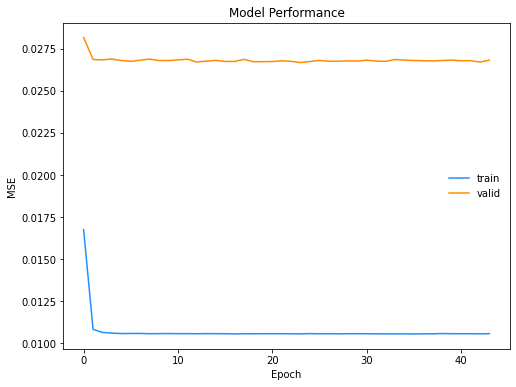

In [53]:
# plot history 
fig = plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], color='dodgerblue', label='train')
plt.plot(history.history['val_loss'], color='darkorange', label='valid')
plt.legend(loc=0, frameon=False)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('Model Performance')
plt.show()

In [22]:
# take the first 'n_steps_in' timesteps from the test set to compare between the model's output and the real values 
sub_test = test[:96]
sub_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 1983-03-15 00:00:00 to 1983-05-01 12:00:00
Freq: 12H
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      96 non-null     float64
 1   X2      96 non-null     float64
 2   X3      96 non-null     float64
 3   Y       96 non-null     float64
dtypes: float64(4)
memory usage: 3.8 KB


In [24]:
# resample as frequency as the original dataset "df" 
st_time_idx = sub_test.index[0]
ed_time_idx = [sub_test.index[-1] + DateOffset(hours=x) for x in range(0, 24+1)]

add_dates = date_range(st_time_idx, ed_time_idx[-1], freq='12H')

future_dates = DataFrame(index=add_dates[0:-2], columns=sub_test.columns)

In [25]:
future_dates.index[0], future_dates.index[-1]

(Timestamp('1983-03-15 00:00:00', freq='12H'),
 Timestamp('1983-05-01 12:00:00', freq='12H'))

In [26]:
future_dates.shape

(96, 4)

In [27]:
sub_test.head(3), ..., sub_test.tail(3)

(                           X1        X2        X3         Y
 DateTime                                                   
 1983-03-15 00:00:00  0.706258  0.517605  0.432338  0.049658
 1983-03-15 12:00:00  0.706258  0.517605  0.432338  0.054475
 1983-03-16 00:00:00  0.706258  0.517605  0.590184  0.054475,
 Ellipsis,
                            X1        X2        X3         Y
 DateTime                                                   
 1983-04-30 12:00:00  0.706258  0.517605  0.432338  0.063485
 1983-05-01 00:00:00  0.706258  0.517605  0.559601  0.063485
 1983-05-01 12:00:00  0.706258  0.517605  0.585184  0.054475)

In [28]:
# demonstrate prediction 
x_input = sub_test[['X2','X3']].values
x_input = x_input.reshape((1, 96, n_features)) # e.g. (timestep, n_in_seq, n_features) 
yhat = model.predict(x_input, verbose=0)
print('\nyhat.shape:', yhat.shape)


yhat.shape: (1, 24)


In [29]:
df_predict = DataFrame(yhat.transpose(), index=future_dates[-24:].index, columns=['Prediction'])

In [30]:
sub_test_without_realY = sub_test.filter(['X1','X2','X3'])

In [31]:
sub_test_without_realY

,X1,X2,X3
DateTime,,,
1983-03-15 00:00:00,0.706258,0.517605,0.432338
1983-03-15 12:00:00,0.706258,0.517605,0.432338
1983-03-16 00:00:00,0.706258,0.517605,0.590184
1983-03-16 12:00:00,0.706258,0.517605,0.552254
1983-03-17 00:00:00,0.706258,0.517605,0.432338
...,...,...,...
1983-04-29 12:00:00,0.706258,0.517605,0.432338
1983-04-30 00:00:00,0.706258,0.517605,0.432338
1983-04-30 12:00:00,0.706258,0.517605,0.432338


In [32]:
df_proj_DF = concat([sub_test_without_realY,df_predict], axis=1)

In [33]:
df_proj_DF.tail(100)

,X1,X2,X3,Prediction
DateTime,,,,
1983-03-15 00:00:00,0.706258,0.517605,0.432338,NaN
1983-03-15 12:00:00,0.706258,0.517605,0.432338,NaN
1983-03-16 00:00:00,0.706258,0.517605,0.590184,NaN
1983-03-16 12:00:00,0.706258,0.517605,0.552254,NaN
1983-03-17 00:00:00,0.706258,0.517605,0.432338,NaN
...,...,...,...,...
1983-04-29 12:00:00,0.706258,0.517605,0.432338,0.127926
1983-04-30 00:00:00,0.706258,0.517605,0.432338,0.128797
1983-04-30 12:00:00,0.706258,0.517605,0.432338,0.130056


In [34]:
# denormalize data 
df_proj = scaler.inverse_transform(df_proj_DF)

In [35]:
df_proj = DataFrame(df_proj, index=df_proj_DF.index, columns=['X1','X2','X3','Prediction'])

In [36]:
df_proj.tail(100)

,X1,X2,X3,Prediction
DateTime,,,,
1983-03-15 00:00:00,1.039535,-7.696444,-8.505444,NaN
1983-03-15 12:00:00,1.039535,-7.696444,-8.505444,NaN
1983-03-16 00:00:00,1.039535,-7.696444,-7.045156,NaN
1983-03-16 12:00:00,1.039535,-7.696444,-7.396059,NaN
1983-03-17 00:00:00,1.039535,-7.696444,-8.505444,NaN
...,...,...,...,...
1983-04-29 12:00:00,1.039535,-7.696444,-8.505444,-0.349507
1983-04-30 00:00:00,1.039535,-7.696444,-8.505444,-0.345855
1983-04-30 12:00:00,1.039535,-7.696444,-8.505444,-0.340575


In [37]:
df_proj = concat([df_proj,sub_test['Y']], axis=1)

In [38]:
df_proj.shape

(96, 5)

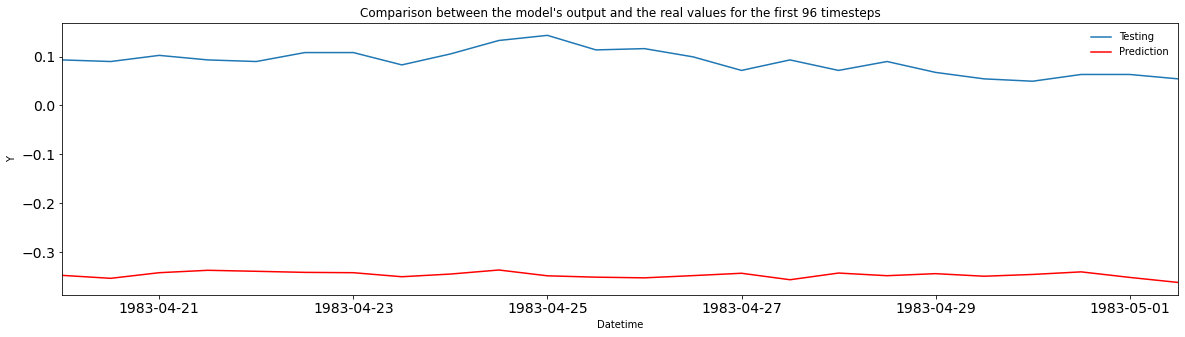

In [42]:
# show a comparison 
plt.figure(figsize=(20,5))
plt.plot(df_proj.index[-24:], df_proj['Y'][-24:], label='Testing')
plt.plot(df_proj.index[-24:], df_proj['Prediction'][-24:], label='Prediction', color='r')
plt.xlabel('Datetime')
plt.ylabel('Y')
plt.legend(loc='best', frameon=False)
plt.title("Comparison between the model's output and the real values for the first "+str(96)+' timesteps')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(left=df_proj.index[-24:][0], right=df_proj.index[-24:][-1])
plt.show()

In [43]:
# demonstrate forecasting beyond the dataset -- Unknown Future 
x_input_forecast = test[['X2','X3']].tail(96).values
x_input_forecast = x_input_forecast.reshape((1, 96, n_features))
yhat_forecast = model.predict(x_input_forecast, verbose=0)
print('yhat_forecast.shape:', yhat_forecast.shape)

yhat_forecast.shape: (1, 24)


In [44]:
# show the last 48 timesteps of the original dataset + 'n_steps_out' hours ahead in the unkown future 
future_time_idx = date_range(to_datetime(test.tail(48).index)[0], periods=48+24, freq='12H')
len(future_time_idx)

72

In [45]:
df_forecast = DataFrame(yhat_forecast.transpose(), index=future_time_idx[-24:], columns=['Forecast'])

In [46]:
test.index[-1], df_forecast.index[0]

(Timestamp('1984-12-31 12:00:00', freq='12H'),
 Timestamp('1985-01-01 00:00:00', freq='12H'))

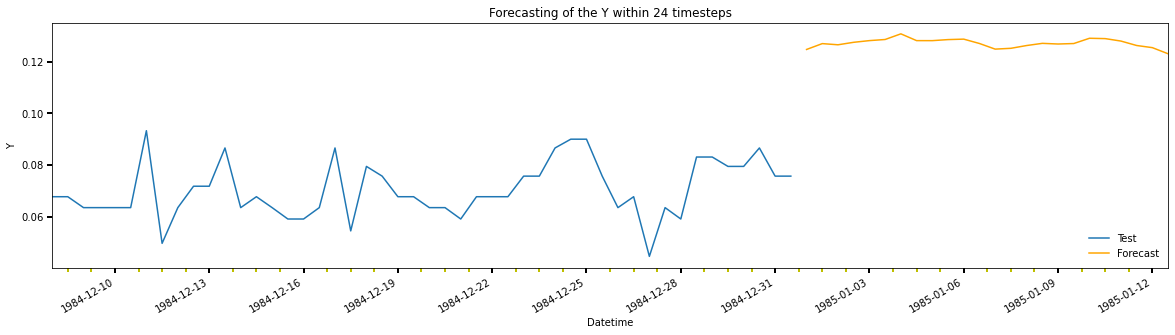

In [47]:
# show the last 48 timesteps + the new forecast 
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(test.index[-48:], test['Y'][-48:], label='Test')
ax.plot(df_forecast.index, df_forecast['Forecast'], label='Forecast', color='orange')

ax.set_xlabel('Datetime')
ax.set_ylabel('Y')
ax.legend(loc=4, frameon=False)

plt.title('Forecasting of the Y within '+str(24)+' timesteps')
plt.xlim(left=test.index[-48:][0], right=df_forecast.index[-1])

ax.xaxis.set_major_locator(MultipleLocator(3))
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=5)
ax.tick_params(which='minor', length=4, color='y')

fig.autofmt_xdate()
plt.show()

### If we took a subset of the dataset in the beginning, we would have the real values in the future. 

### In that case, we could compare between the LSTM NN output with the real values. 

### If we worked on the whole dataset, we would be able to forecast the unknown future by feeding the last timesteps to the trained model. 

In [48]:
# show the model error 
print('RMSE = %.3f' % rmse(df_raw['Y'][-24:], df_proj['Prediction'][-24:]))
print('Min MSE = %.3f' % min(history.history['loss']))
print('Min MSE_val_loss = %.3f' % min(history.history['val_loss']))

RMSE = 0.239
Min MSE = 0.011
Min MSE_val_loss = 0.027


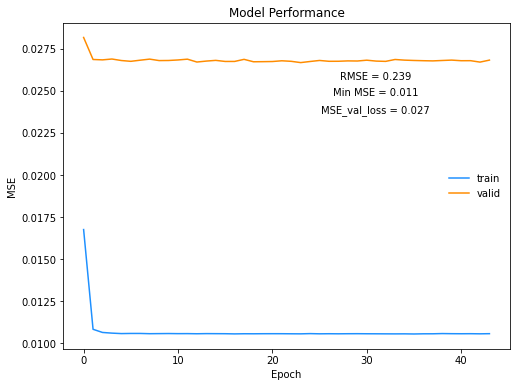

In [52]:
# plot history 
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.plot(history.history['loss'], color='dodgerblue', label='train')
plt.plot(history.history['val_loss'], color='darkorange', label='valid')
plt.legend(loc=0, frameon=False)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('Model Performance')

plt.text(0.7, 0.85, 'RMSE = '+'{:.3f}'.format(sqrt(mean_squared_error(df_raw['Y'][-24:], df_proj['Prediction'][-24:]))), horizontalalignment='center', verticalalignment='top', transform = ax.transAxes)
plt.text(0.7, 0.80, 'Min MSE = '+'{:.3f}'.format(min(history.history['loss'])), horizontalalignment='center', verticalalignment='top', transform = ax.transAxes)
plt.text(0.7, 0.75, 'MSE_val_loss = '+'{:.3f}'.format(min(history.history['val_loss'])), horizontalalignment='center', verticalalignment='top', transform = ax.transAxes)

plt.show()